# Building Spatial Database for GIS data 

## Motivation and Introduction

We live in a fast growing world. I am always amazed by how mother earth has evolved over the history. Back in the days when we don't have computers, I can not imagine how hard it was for cartographers to draw all those maps by hand and preserve them for so many years. But nowadays, map making has become much more manageable with the help of advanced geo-coding applications and database storage systems. <br>

In this tutorial, we will walk through how to represent geographical features in <a href="http://geojson.org/">GeoJSON</a> format, and how to ingest and extract data from <a href='https://www.postgresql.org/'>PostgreSQL</a> database with <a href='https://postgis.net/'>PostGIS</a> plugin.



### Content

The data for this tutorial is the same as the previously provided  <a href='https://nbviewer.jupyter.org/url/www.datasciencecourse.org/tutorial/gis_tutorial.ipynb'>gis_tutorial</a>, which is from Pittsburgh GIS data repository of the city's planning department: http://pittsburghpa.gov/dcp/gis/gis-data-new. We will look into the Land_Management.zip data which can be downloaded from: http://apps.pittsburghpa.gov/dcp/Land_Management.zip. Primarily, the following 2 shapefiles (included with this tutorial):
	- Neighborhood.zip
	- City_Address_Points.zip

Section layout:

- [Installing the libraries and PostgreSQL](#Installing-the-libraries-and-PostgreSQL)
- [Loading the data](#Loading-the-data)
- [GeoJSON representation](#GeoJSON Representation)
- [Building spatial database](#Building-spatial-database)
- [Ingesting data](#Ingesting-data)
- [Spatial queries](#Spatial-queries)
- [Extracting data](#Extracting-data)

## Installing the libraries and PostgreSQL

In this tutorial we need:<br>
       <a href='https://pypi.python.org/pypi/pyshp'>pyshp</a>: Python's I/O support for ESRI Shapefile <br>
       <a href='http://initd.org/psycopg/docs/'>psycopg</a>: Database adapter for PostgreSQL <br>
       <a href='https://docs.python.org/2/library/pprint.html'>pprint</a>: To pretty-print the data<br>
       
I installed my libraries with:

    $ pip install --upgrade pyshp psycopg2 pprint
       

<br>
PostgreSQL can be downloaded <a href = 'https://www.postgresql.org/download/'>here</a>. Please choose the link that belongs to your environment with version above 10+. <br> I downloaded the installer executable, and it went pretty smooth for me. In between, the installer client will ask you to select components to install. Make sure you checked both boxes to install PostGIS plugin, as well as creating a default spatial database on localhost. <br><br>


<img src="install2.png",width=550,height=450>

<br>
<a href= 'https://www.pgadmin.org/'>PgAdmin</a> (Optional) is the most popular development platform for PostgreSQL. Feel free to also install it if you prefer viewing data and performing queries from a fancier interface.


## Loading the data
We are going to first load the Neighborhood.zip and City_Address_Points.zip data. Since the shapefile comes with .zip format, the following code snippet demostrates how to load shapefiles with the help of pyshp library's <b>shapefile.Reader()</b> function.

#### More about the ESRI Shapefile:
Shapefile is a format to store geospatial vector data. If you happen to look into the zip file, you might have noticed all that different file extensions. But only 3 of them comes necessary for our reader (referencing <a href="https://en.wikipedia.org/wiki/Shapefile">Shapefile</a> Wikipedia page here, and for full specifications):

    -.shp — shape format; the feature geometry itself
    -.shx — shape index format; a positional index of the feature geometry
    -.dbf — attribute format; columnar attributes for each shape


In [1]:
import shapefile
import zipfile
import io

def read_shapefile_from_zip (zip_path):
    file_archive = zipfile.ZipFile(open(zip_path, "rb"))
    
    extensions = ['.shp', 'dbf', 'shx']
    file_data = []
    for extension in extensions: 
        data = [y for y in file_archive.namelist() if extension in y][0]
        file_data.append(io.BytesIO(file_archive.read(data)))
    
    return shapefile.Reader(shp=file_data[0], dbf=file_data[1], shx=file_data[2])

<br>
We can call the above <b>read_shapefile_from_zip()</b> function and pass in our zip file. We can also take a peak at what properties (aka "column names") our neighborhood have besides geometries:

In [2]:
reader = read_shapefile_from_zip ('Neighborhood.zip')
properties = [f[0] for f in reader.fields]
print ("Field properties are: \n%s \n" % properties)

Field properties are: 
['DeletionFlag', 'FID_BlockG', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'Shape_Leng', 'FID_Neighb', 'AREA', 'PERIMETER', 'NEIGHBOR_', 'NEIGHBOR_I', 'HOOD', 'HOOD_NO', 'ACRES', 'SQMILES', 'DPWDIV', 'UNIQUE_ID', 'SECTORS', 'Shape_Le_1', 'Shape_Ar_1', 'Shape_Le_2', 'Shape_Area', 'Page_Numbe'] 



#### Limitations with Shapefile:

Although shapefile format has been so vastly used for decade, it also comes with drawbacks. Here's a link to the article <a href="http://switchfromshapefile.org/">"Shapefile must die!"</a> for some funny read.


Say if you are hosting a client level application that constantly streams in new GIS data, suppose you want to slightly update a few shapes. It would be extremely inefficient to pass this information in the format of shapefile (back and forth between your front-end interface and back-end server).  Rather, a fast and lightweight data representation in GeoJSON format is more simple and human readable (specificly, it is recommanded as shapefile replacement for data interchange).

## GeoJSON Representation

As you can tell by the name itself, GeoJSON is based on JSON. GeoJSON uses generic format to represent features with various geometry classes. Here is the example of a <b>Feature</b> json object (from http://geojson.org/):

<pre>
{
  "type": "Feature",
  <font color='red'>"geometry": {
    "type": "Point",
    "coordinates": [125.6, 10.1]
  },</font>
  <font color='blue'>"properties": {
    "name": "Dinagat Islands"
  }</font>
}
</pre>

In our neighborhood data, each entry will be treated as one feature. And the 3 keys are:

    - type: always "Feature"
    - geometry: This is how GeoJSON represents various shapes in human readable format - coordinates list(s)
    - properties: a json (dictionary) of fields: values mapping.

You can always think of maps as all sorts of geometries layered together. More detailed json examples for each of these classes can be fond on the <a href = 'https://en.wikipedia.org/wiki/GeoJSON#Geometries'>GeoJSON wikipedia page</a>. Here are all the supported types: <br>
Geometry primitives: <b>Point, LineString, Polygon</b> <br>
Multipart geometries: <b>MultiPoint, MultiLineString, MultiPolygon</b>

So the Neighborhood shapefile cotains 91 records, which we will wrap all of them in a <b>FeatureCollection</b> json: 

<pre>
{
  "type": "FeatureCollection",
  <font color='red'>"features": [] </font>
}
</pre>

Where "features" is a json array consisting of 91 features' json objects.



### Converting Shapefile to GeoJSON

Just to re-iterate, we need 3 keys for our feature json: "type", "geometry" and "properties". 
Referencing the <b>reader.shapeRecords()</b> function in psyshp <a href='https://github.com/GeospatialPython/pyshp/wiki/ShapeRecords'>wiki</a>, we can write the following function to take in a shapefile and convert it to GeoJSON format.

In [3]:
import json
import pprint

def shapefile_to_geojson (reader):
    json_array = [] 
    # starting at index 1 because there is no 'DeletionFlag' field in our original data (this field is added by dbf)
    properties = [f[0] for f in reader.fields[1:]]
    count = 0
    for feature in reader.shapeRecords():
        # get shape's geometry
        geom = feature.shape.__geo_interface__
            
        # serializing the properties mapping to dictionary
        prop = dict(zip(properties, feature.record))
           
        # add each feature to the array under the same feature collection
        json_array.append({"type": "Feature", "geometry": geom, "properties": prop})  
        
    feature_collection = json.dumps({"type": "FeatureCollection", "features": json_array}, default=str)     
    return json.loads(feature_collection)

A json object is returned after calling the above function, which you can access it as a dictionary. Here you can tell the geometries are Polygons. I also printed out the properties of the first feature in our collection.

In [4]:
pp = pprint.PrettyPrinter()
neighbor_feature_collection = shapefile_to_geojson(reader)

print ("Number of features in neighborhood: %d" %len(neighbor_feature_collection['features']))
print ("Features are of type: %s\n" %(neighbor_feature_collection['features'][0]['geometry']['type']))

pp.pprint(neighbor_feature_collection['features'][0]['properties'])

Number of features in neighborhood: 91
Features are of type: Polygon

{'ACRES': 180.883,
 'ALAND10': 268195.0,
 'AREA': 7843108.0,
 'AWATER10': 0.0,
 'BLKGRPCE10': '1',
 'COUNTYFP10': '003',
 'DPWDIV': 3,
 'FID_BlockG': 0,
 'FID_Neighb': 62,
 'FUNCSTAT10': 'S',
 'GEOID10': '420030405001',
 'HOOD': 'Central Oakland',
 'HOOD_NO': 20,
 'INTPTLAT10': '+40.4406805',
 'INTPTLON10': '-079.9542332',
 'MTFCC10': 'G5030',
 'NAMELSAD10': 'Block Group 1',
 'NEIGHBOR_': 63,
 'NEIGHBOR_I': 2145,
 'PERIMETER': 11526.863,
 'Page_Numbe': 0,
 'SECTORS': 14,
 'SQMILES': 0.281,
 'STATEFP10': '42',
 'Shape_Ar_1': 7843108.22191,
 'Shape_Area': 7842996.64181,
 'Shape_Le_1': 11526.8632219,
 'Shape_Le_2': 11525.9045464,
 'Shape_Leng': 7988.37939146,
 'TRACTCE10': '040500',
 'UNIQUE_ID': 113}


<br>
Becuase we wrote helper functions, we can now directly use them to load City_Address_Points data and convert it to geojson. Here I also printed the first feature (not just properties, but also types and geometries.. as point features have shorter json string to fit in the display area):

In [5]:
address_reader = read_shapefile_from_zip ('City_Address_Points.zip')
address_feature_collection = shapefile_to_geojson(address_reader)

print ("Number of features in city_address: %d" % len(address_feature_collection['features']))
print ("Features are of type: %s\n" %(address_feature_collection['features'][0]['geometry']['type']))

pp.pprint (address_feature_collection['features'][0])

Number of features in city_address: 119819
Features are of type: Point

{'geometry': {'coordinates': [1340436.7047723383, 420704.9560229033],
              'type': 'Point'},
 'properties': {'ADDR_NUM': '2219',
                'CreatedBy': '',
                'CreatedOn': '',
                'EXP_FLAG': '',
                'E_OVERRIDE': '',
                'FULL_ADDRE': '2219 OSGOOD ST',
                'F_OVERRIDE': '',
                'MUNICIPALI': 'PITTSBURGH',
                'ModifiedBy': '',
                'ModifiedOn': '',
                'P_OVERRIDE': '',
                'SOURCE': 'GDR',
                'ST_NAME': 'OSGOOD',
                'ST_PREFIX': '',
                'ST_SUFFIX': '',
                'ST_TYPE': 'ST',
                'ZIP_CODE': '15214'},
 'type': 'Feature'}


## Building spatial database

Database operations are transactional! This allows people to easily update entries, maintain logs, keep backups etc. Also database systems are relatively flexible in terms of granting users the right amount of access.  

### Connecting to database
We are finally at the database level!  But first of all, we need to set up our connection to the database. As demostrated in the code below, I am simply connecting to the default database created during installation stage. Also a better coding standard for connection credentials would be putting all the details in a seperate file (outside the codebase). Only for the purpose of this demo I am hard coding all the default credentials, but viewers should feel free to create and use their own database.

In [6]:
import psycopg2

try:
    # user should replace this credential to connect to their own database.
    conn = psycopg2.connect(user='postgres', password='password', host='localhost', dbname='postgres')
    conn.autocommit = True
except:
    print ("Failed to connect to database")
    
cur = conn.cursor()

# need to add postgis extension to newly created database.
cur.execute("CREATE EXTENSION IF NOT EXISTS postgis;")
cur.execute('SELECT version()')
print ("Version: %s\n" % cur.fetchone())

Version: PostgreSQL 10.2, compiled by Visual C++ build 1800, 64-bit



### Creating Tables
Now lets think about the table schema. If we treat each row in the table as one feature entry, then we will need to keep at least 3 essential columns (for each row):
1. some primary key
2. the geometry of the feature
3. all the properties

<br>
<font color='black'>Surely there are fancy command-line and interface tools to directly import a shapefile into a database table. But the result table will strictly follow the shapefile schema (which is creating a column for each coresponding field). This is a downside we do not want to have because it brings in extra redundency, as well as not being memory friendly. (eg: our Neighborhood data has over 30 properties and we do not want to create that many columns!) </font>

Instead, we would like to take the advantage of GeoJSON being "JSON", which means to store ALL the properties in one column with type JSON. This will get rid of lots of column spaces. Postgres also added indexing support on json data types after version 9.4, which is always nice to make our queries faster. <br>

So all we need are the following 3 columns (with id being a primary key):


| Column_Name | Type  |
|-------------|-------|
|   id        | serial |
|   geom        | geometry |
|   properties        | json |

Of course this is the bare minimum. Some other columns are still worthy to maintain, such as identifier for each feature ('FID_BlockG' field under Neighborhood), insert/transaction timestamp, feature version (for feature updates) and so on. We can now write our create table query:


In [7]:
def create_gis_table (cur, table_name):
    query = "CREATE TABLE IF NOT EXISTS %s (id serial PRIMARY KEY, geom geometry, properties json);" % table_name
    # adding index on the geometry column upon table creation to speed up spatial operations.
    query += "CREATE INDEX %s_geom_idx ON %s USING GIST (geom);" % (table_name, table_name)
    cur.execute(query)

Go ahead and create 2 tables:

In [8]:
create_gis_table (cur, "neighborhood")
create_gis_table (cur, "city_address")

## Ingesting data

The sql query to insert one feature record into our gis table should look like: <br>
    <center><font color = 'blue'> INSERT INTO table_name VALUES (DEFAULT, geometry, properties); </font></center>
    
But here want to use batch insert instead of adding the records one by one (because the city_address shapefile has over 100,000 entries). So i defined the following function to pass in a size paramter for the sql batch updates. This is generally better practise than single-feature "INSERT" transactions, as it executes much faster. <br>
    <center><font color = 'blue'> INSERT INTO table_name VALUES <br>(DEFAULT, geometry_0, properties_0), <br> (DEFAULT, geometry_1, properties_1),<br>... <br>(DEFAULT, geometry_n, properties_n); </font></center>


In [9]:
def insert_feature_collection_to_table (table_name, feature_collection, batch_size):
    count = 1
    size = len (feature_collection['features'])
    sub_clause = ""
    
    for feature in feature_collection['features']:
        sub_clause += "(DEFAULT, ST_GeomFromGeoJSON('%s'), '%s')," % \
                        (json.dumps(feature['geometry']), json.dumps(feature['properties']))    
            
        if count % batch_size == 0 or count == size:
            query = "INSERT INTO %s VALUES %s;" % (table_name, sub_clause[:-1])
            cur.execute(query)
            sub_clause = ""
        count += 1
    
    cur.execute("select count(*) from %s" % table_name)
    return cur.fetchone()

Now we can insert our neighborhood geojson and city_address geojson into our tables with a batch size of 1000. (You do have to be carefully not to reach the maximum query string length allowed by PostgreSQL). The results are shown below:

In [10]:
neighbor_count = insert_feature_collection_to_table("neighborhood", neighbor_feature_collection, 1000)
address_count = insert_feature_collection_to_table("city_address", address_feature_collection, 1000)

print ("neighborhood table now has：%d rows." % neighbor_count)
print ("city_address table now has：%d rows.\n" % address_count)

neighborhood table now has：91 rows.
city_address table now has：119819 rows.



## Spatial queries

Here goes the full PostGIS Reference for all the functions: https://postgis.net/docs/reference.html. There are so many intersting things we can do with spatial operations, let's play with some examples.


#### Spatial Query Example 1: <font color='blue'>ST_INTERSECTS </font>

When I tell people I live at 144 N Dithridge Street, usually the conversation goes right after: "Which neighborhood is that?". Looking at the Neighborhood and city_address files alone we can not get this information from attributes. However we can easily perform a spatial join to find the neighborhood polygon that intersects with my point address.



In [11]:
def address_neighbourhood_lookup (address, cursor):
    query = "SELECT n.properties->'HOOD' \
                FROM neighborhood n, city_address addr \
                WHERE addr.properties->>'FULL_ADDRE' = '%s' \
                AND ST_INTERSECTS(addr.geom, n.geom)" % address

    cur.execute(query)
    return cursor.fetchone()[0]

res  = address_neighbourhood_lookup('144 N DITHRIDGE ST', cur)
print (res)

North Oakland


#### Spatial Query Example 2: <font color = 'blue'>ST_TOUCHES </font>
So I am now wondering what other neighborhoods are surrouded by the place i live in, we can just read the adjacent polygons that touches my arbitrary polygon. 

In [12]:
def adjancent_neighborhood_lookup(center, cursor):
    query = "SELECT n2.properties->'HOOD' \
                            FROM neighborhood n1, neighborhood n2 \
                            WHERE n1.properties->>'HOOD' = '%s' \
                            AND ST_TOUCHES(n1.geom, n2.geom)" % center

    cursor.execute(query)
    return cur.fetchall()
    
adjacent_hoods = adjancent_neighborhood_lookup ("North Oakland", cur)
print ("Neighborhood is adjacent with:\n\n%s\n" % ('\n'.join(str(x[0]) for x in adjacent_hoods)))

Neighborhood is adjacent with:

Central Oakland
West Oakland
Lower Lawrenceville
Bloomfield
Shadyside
Polish Hill
Squirrel Hill North
Terrace Village
Upper Hill



#### Spatial Query Example 3: <font color = 'blue'>ST_CONTAINS</font>
Suppose I am now curious to know the range of zip code for each neighborhood. I can perform a query to find the point address contained by each neighborhood polygon and group their zip code into a list with <b>string_agg()</b> function. 

An interesting finding here is 'Terrace Village' actually has 51219 as one of its zip code (more likely should have been 15219), so apparently human errors are involved even with goverment data.

In [13]:
def neighbourhood_zipcode_lookup(cur):
    query = "SELECT n.properties->>'HOOD', \
                                    string_agg (DISTINCT (addr.properties->>'ZIP_CODE'), ',') \
                                    FROM city_address addr, \
                                        neighborhood n \
                                    WHERE ST_Contains(n.geom, addr.geom) \
                                    GROUP BY n.properties->>'HOOD' \
                                    ORDER BY n.properties->>'HOOD' DESC"

    cur.execute(query)
    return cur.fetchall()

res = neighbourhood_zipcode_lookup (cur)
print('\n'.join(str(x) for x in res[0:10]))
 

('Windgap', '15136,15204,15205')
('Westwood', '15205,15220')
('West Oakland', '15213,15219,15261')
('West End', '15220')
('Upper Lawrenceville', '15201')
('Upper Hill', '15213,15219')
('Troy Hill', '15212,15222')
('Terrace Village', '15213,15219,15261,51219')
('Swisshelm Park', '15217,15218')
('Summer Hill', '15212,15214')


## Extracting data

We have just demostrated how to insert features and run some spatial queries. Assume you have maintained this database for some period and constantly populating new entries and updates. At some point, you would love to extract the data out from the tables and serve it to your stakeholders. The following code explains how to read data out and deliever them as geojson format. 


Again after Postgres version 9.4, user can call <b><a href = https://www.postgresql.org/docs/9.4/static/functions-json.html> json_build_object() </a></b> function to wrap up a JSON object inside the SQL statement. 
Recall the GeoJson format, a featureCollection contains an array list of features (json objects). So we can again use the aggregation function <b>json_agg()</b> to group all the rows from a SELECT clause.


In [14]:
def table_to_feature_collection_json (table_name, cursor):
    query = "SELECT jsonb_build_object('type','FeatureCollection', 'features', json_agg(feature)) \
                    FROM (SELECT jsonb_build_object ('type', \
                                                    'Feature', \
                                                    'geometry',   ST_AsGeoJSON(geom)::json,\
                                                    'properties', to_jsonb(row) - 'geom') \
                    AS feature FROM \
                        (SELECT * FROM %s) row) features;" % table_name
    
    cursor.execute(query)
    return cursor.fetchone()[0]
    
neighbor_json_obj = table_to_feature_collection_json ("neighborhood", cur)
print ("Loaded out %d features from table. \n" % (len(neighbor_json_obj['features'])))

Loaded out 91 features from table. 



At last I just want to add one small visulization example. We can use matplotlib & <a href='https://pypi.python.org/pypi/descartes'>descartes</a> to plot the geometry JSON that we just extracted from the database:

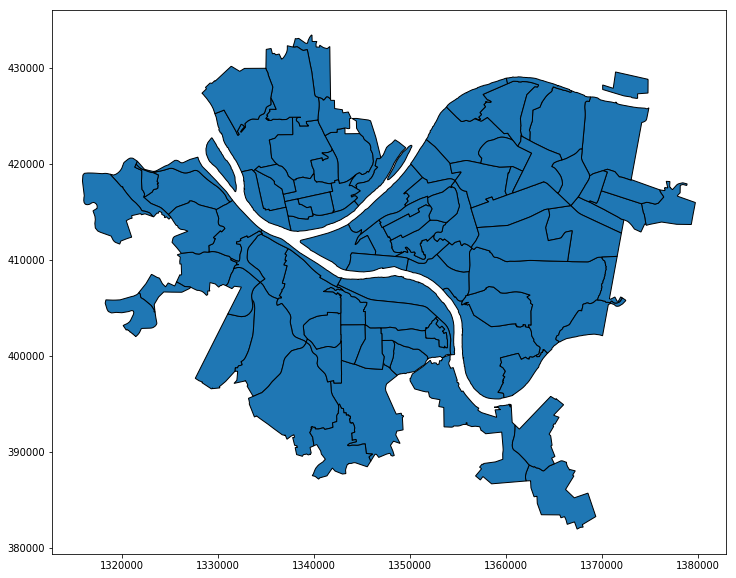

In [16]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch

fig = plt.figure(figsize=(20,10)) 
ax = fig.gca() 
for feature in neighbor_json_obj['features']:
    ax.add_patch(PolygonPatch(feature['geometry']))    
ax.axis('scaled')
plt.show()

## Additional relevent tools and readings:

<b>geojson.io</b>: for visualizing geojson on the acutal world map <br>
http://geojson.io/#map=2/20.0/0.0 (web)<br> 
https://pypi.python.org/pypi/geojsonio/0.0.3 (python) <br>

<b>jsonschema</b>: for schema validations & data sanity checks <br>
https://pypi.python.org/pypi/jsonschema <br>

<b>streaming</b>: Large datasets I/O should be handled with streaming rather than loading everything into memory at once <br>
https://pypi.python.org/pypi/streaming/0.1.2 <br>

<b>Map Projections</b>: (Wondering why our neighborhood coordinates aren't really readable latitudes and longtitudes?) Earth is round but canvas is flat :)<br>
https://en.wikipedia.org/wiki/Map_projection <br>
http://spatialreference.org/ref/epsg/ 


## Summary and references:

Shapefile: https://en.wikipedia.org/wiki/Shapefile <br>
Pyshp: https://pypi.python.org/pypi/pyshp <br>
GeoJSON: http://geojson.org/, https://en.wikipedia.org/wiki/GeoJSON <br>
Psycopg: http://initd.org/psycopg/ <br>
PostgreSQL: https://www.postgresql.org/docs/10/static/index.html <br>
PostGIS: https://postgis.net/docs/reference.html <br>
descartes: https://pypi.python.org/pypi/descartes<br>
